<a href="https://colab.research.google.com/github/PadmajaVB/Sexist-Statement-Detection/blob/main/Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model without embeddings

Architecture used from this paper: https://arxiv.org/abs/1801.04433

**Importing libraries and cleaning the data**

In [25]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import re
import collections

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
df_train = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv", index_col=0)
df_val = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/val_dataset.csv", index_col=0)
df_test = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/test_dataset.csv", index_col=0)

df_train.head()

,Sentences,Label
0,after receiving positive comments for some des...,1
1,i love how all the lynx space YMCA adverts ass...,0
2,aye even here these dolts still see us as poss...,1
3,why are cold showers good for you,0
4,im a physicist and i worked on vacuum systems ...,1


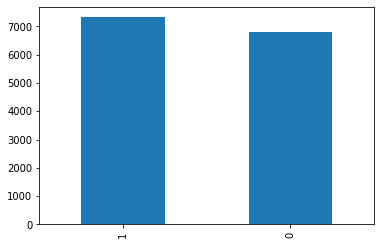

In [28]:
# do some exploratory data analysis
df_train['Label'].value_counts().plot(kind='bar')

In [29]:
# clean the data
def clean_data(df):
  df.Sentences = [element.lower() for element in df.Sentences]
  df.Sentences = [re.sub(r'[^a-zA-Z /n]', '', element) for element in df.Sentences]
  df.Sentences = ['<s> '+ element + ' </s>' for element in df.Sentences]
  return df

In [30]:
df_train = clean_data(df_train)
df_val = clean_data(df_val)
df_test = clean_data(df_test)

**Tokenizing text with a fixed vocabulary size**

In [31]:
vocab_size = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='UNK'
)

tokenizer.fit_on_texts(df_train["Sentences"])
train_data = tokenizer.texts_to_sequences(df_train["Sentences"])
reverse_dict = {j:i for i,j in tokenizer.word_index.items()}

In [32]:
val_data = tokenizer.texts_to_sequences(df_val["Sentences"])
test_data = tokenizer.texts_to_sequences(df_test["Sentences"])

**Create tf.Dataset**

In [33]:
def create_dataset(x,y):
  ragged_x = tf.ragged.constant(x)
  ragged_y = tf.ragged.constant(y)
  dataset = tf.data.Dataset.from_tensor_slices((ragged_x,ragged_y))
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(32)
  dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None]), y), num_parallel_calls=3)
  dataset = dataset.prefetch(3)
  return dataset

In [34]:
dataset_train = create_dataset(train_data, df_train["Label"])
dataset_val = create_dataset(val_data, df_val["Label"])
dataset_test = create_dataset(test_data, df_test["Label"])

In [35]:
print(dataset_train)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.int32, tf.int64)>


**Define and train model**

In [18]:
Inputs=  tf.keras.layers.Input(shape=(None,))
Embedding= tf.keras.layers.Embedding(vocab_size, 30)(Inputs)
LSTM_1= tf.keras.layers.LSTM(200, return_sequences=False)(Embedding)
Dense= tf.keras.layers.Dense(10, activation= 'relu')(LSTM_1)
Output = tf.keras.layers.Dense(1,activation='sigmoid')(Dense)

model= tf.keras.Model(inputs= Inputs, outputs= Output)

model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 30)          150000    
_________________________________________________________________
lstm (LSTM)                  (None, 200)               184800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 336,821
Trainable params: 336,821
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(dataset_train, epochs=10, validation_data=dataset_val)

Epoch 1/10
441/441 [==============================] - 253s 570ms/step - loss: 0.6928 - accuracy: 0.5177 - val_loss: 0.6910 - val_accuracy: 0.5495
Epoch 2/10
441/441 [==============================] - 243s 553ms/step - loss: 0.6925 - accuracy: 0.5187 - val_loss: 0.6905 - val_accuracy: 0.5495
Epoch 3/10
441/441 [==============================] - 249s 565ms/step - loss: 0.6925 - accuracy: 0.5187 - val_loss: 0.6905 - val_accuracy: 0.5495
Epoch 4/10
441/441 [==============================] - 245s 556ms/step - loss: 0.6925 - accuracy: 0.5187 - val_loss: 0.6904 - val_accuracy: 0.5495
Epoch 5/10
441/441 [==============================] - 245s 557ms/step - loss: 0.6925 - accuracy: 0.5187 - val_loss: 0.6904 - val_accuracy: 0.5495
Epoch 6/10
441/441 [==============================] - 246s 558ms/step - loss: 0.6925 - accuracy: 0.5187 - val_loss: 0.6904 - val_accuracy: 0.5495
Epoch 7/10
441/441 [==============================] - 243s 551ms/step - loss: 0.6925 - accuracy: 0.5187 - val_loss: 0.6904 -

**Plotting loss and accuracy**

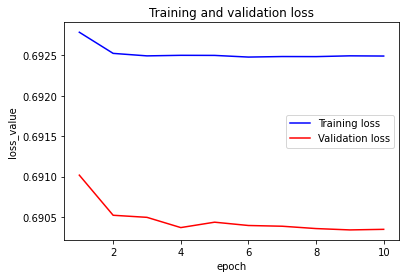

In [22]:
loss = history.history['loss']
epochs = range(1,len(loss)+1)
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, '-r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend()
plt.show()

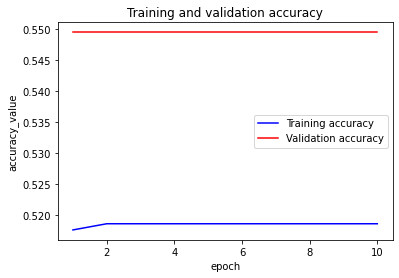

In [23]:
loss = history.history['accuracy']
epochs = range(1,len(loss)+1)
val_loss = history.history['val_accuracy']
plt.figure()
plt.plot(epochs, loss, 'b', label='Training accuracy')
plt.plot(epochs, val_loss, '-r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy_value')
plt.legend()
plt.show()

**Evaluating on test data**

In [24]:
result = model.evaluate(dataset_test)
dict(zip(model.metrics_names, result))

8/8 [==============================] - 0s 23ms/step - loss: 0.6904 - accuracy: 0.5482


{'accuracy': 0.5482456088066101, 'loss': 0.6904306411743164}